
## Import necessary libraries

In [1]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

C:\Users\luisl\AppData\Local\Temp\ipykernel_23760\269888456.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [4]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [5]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load and process input data

Check the texts which is filtered by keyword as well

In [6]:
import pickle
import os

# Rutas de los archivos
ruta_original = 'C:/Users/Luis/Desktop/personal/tfm_ia3_nodata/data/preprocessed/'
ruta_nueva = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/'
archivos = ['text_no_split.pickle', 'text_keyword.pickle']

# Intentar cargar los archivos
text_no_split = None
text_keyword = None

for archivo in archivos:
    try:
        # Intenta abrir el archivo en la ruta original
        with open(os.path.join(ruta_original, archivo), 'rb') as file:
            if archivo == 'text_no_split.pickle':
                text_no_split = pickle.load(file)
            elif archivo == 'text_keyword.pickle':
                text_keyword = pickle.load(file)
        print(f"Archivo {archivo} encontrado en la ruta original.")
    except FileNotFoundError:
        try:
            # Si no se encuentra en la ruta original, intenta en la nueva
            with open(os.path.join(ruta_nueva, archivo), 'rb') as file:
                if archivo == 'text_no_split.pickle':
                    text_no_split = pickle.load(file)
                elif archivo == 'text_keyword.pickle':
                    text_keyword = pickle.load(file)
            print(f"Archivo {archivo} encontrado en la nueva ruta.")
        except FileNotFoundError:
            print(f"Archivo {archivo} no encontrado en ninguna de las rutas.")

# Usar las variables text_no_split y text_keyword según sea necesario.


Archivo text_no_split.pickle encontrado en la nueva ruta.
Archivo text_keyword.pickle encontrado en la nueva ruta.


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


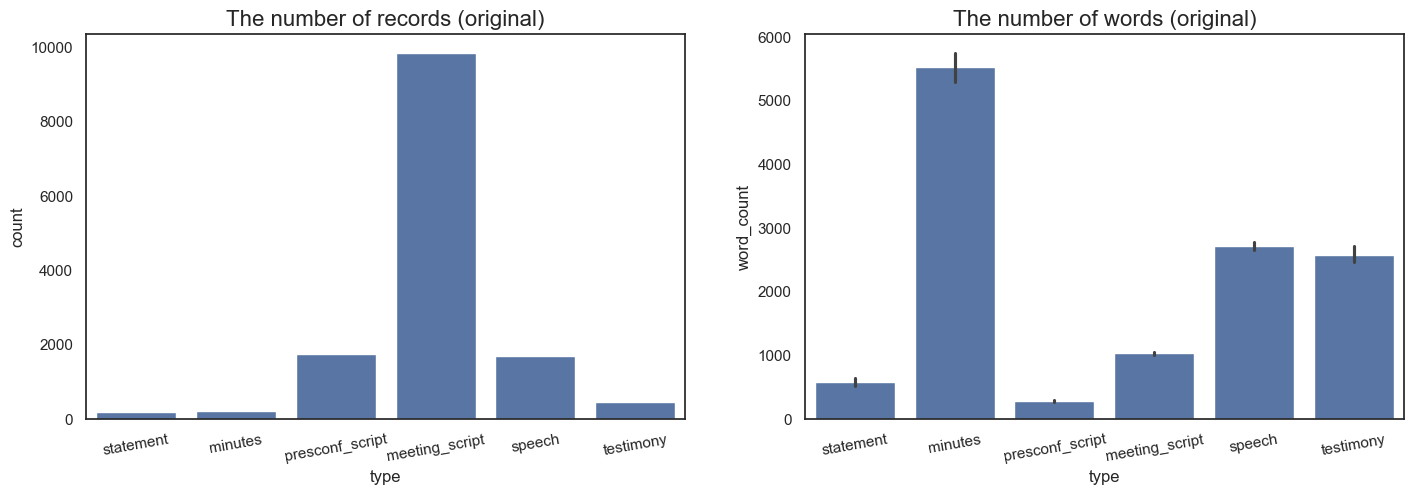

In [7]:
# Check the number of records per document type
def plot_num_rec_word(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)

# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,403,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,432,1,5.50,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,400,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


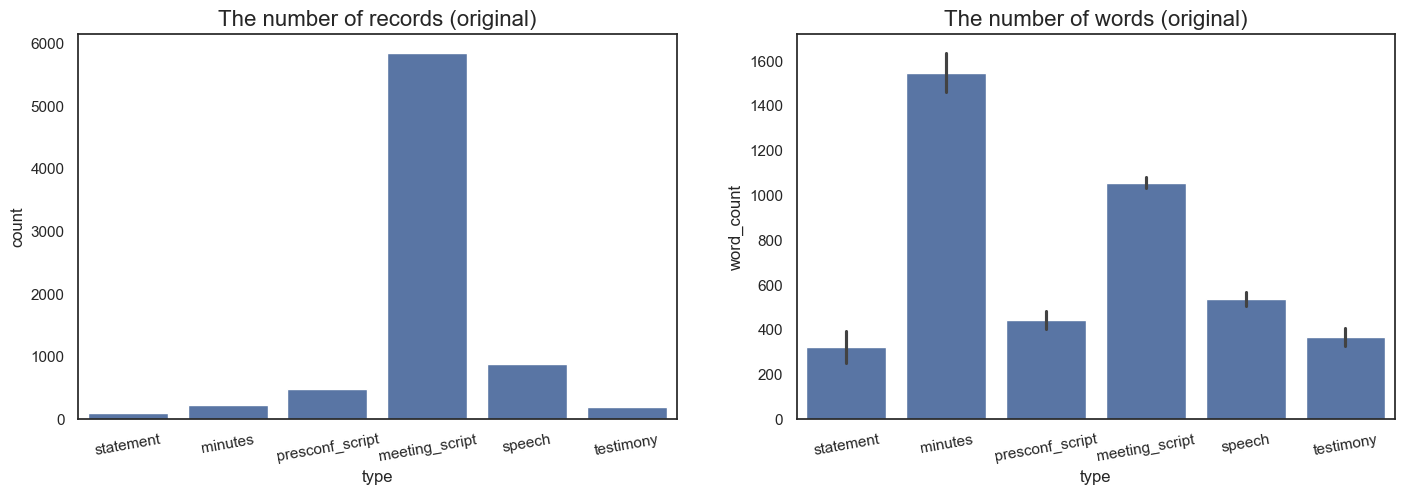

In [8]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [9]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe
Here, use all the texts but keywords filtere one would give better performance - to be checked.

(4339, 11)


  0%|          | 0/9852 [00:00<?, ?it/s]

(4597, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


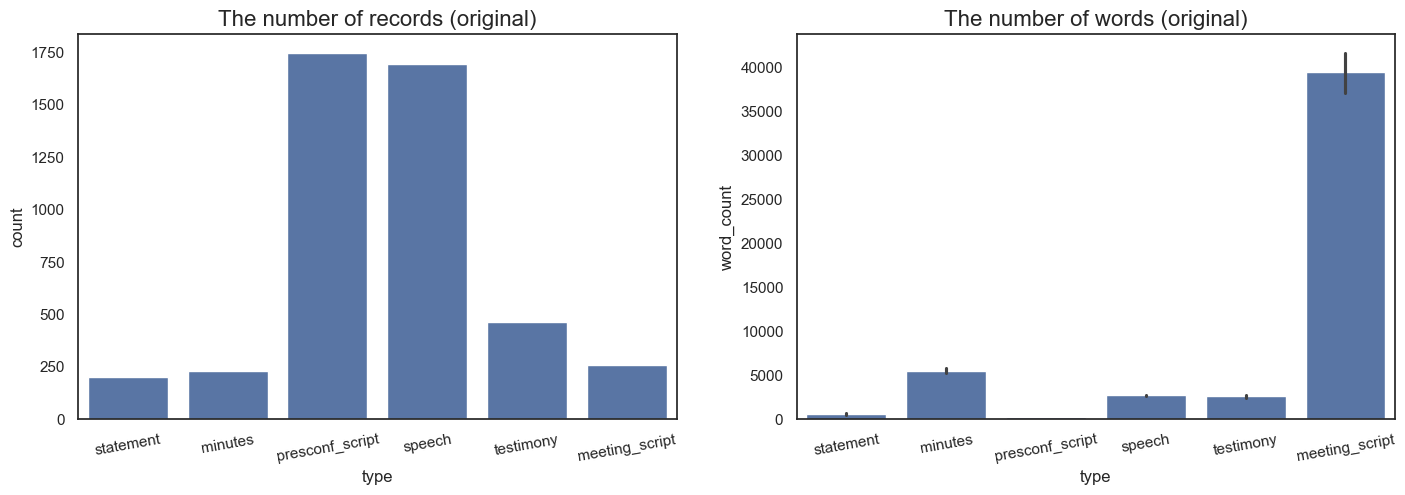

In [10]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row

    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

In [11]:
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [12]:
# Calcular el número total de filas en el DataFrame
num_total_filas = train_df.shape[0]

print("Número total de filas en el DataFrame:", num_total_filas)

Número total de filas en el DataFrame: 4597


In [13]:
# Supongamos que tienes un DataFrame llamado df y una variable específica llamada 'variable_especifica'
variable_especifica = 'next_decision'

# Contar el número de filas con valores NaN en la variable especificada
num_filas_nan = train_df[variable_especifica].isnull().sum()

print("Número de filas con NaN en la variable '{}': {}".format(variable_especifica, num_filas_nan))


Número de filas con NaN en la variable 'next_decision': 31


In [14]:
# Filtrar el DataFrame para seleccionar solo las filas con valores NaN en la variable especificada
filas_nan = train_df[train_df[variable_especifica].isnull()]

# Obtener los valores de la columna "date" correspondientes a las filas con valores NaN
fechas_nan = filas_nan['date']

print("Valores de 'date' correspondientes a filas con NaN en la variable '{}':".format(variable_especifica))
print(fechas_nan)

Valores de 'date' correspondientes a filas con NaN en la variable 'next_decision':
201    2023-12-13
2151   2023-12-13
2152   2023-12-13
2153   2023-12-13
2154   2023-12-13
2155   2023-12-13
2156   2023-12-13
2157   2023-12-13
2158   2023-12-13
2159   2023-12-13
2160   2023-12-13
2161   2023-12-13
2162   2023-12-13
2163   2023-12-13
2164   2023-12-13
2165   2023-12-13
2166   2023-12-13
2167   2023-12-13
2168   2023-12-13
2169   2023-12-13
2170   2023-12-13
2171   2023-12-13
2172   2023-12-13
2173   2023-12-13
2174   2023-12-13
2175   2023-12-13
2176   2023-12-13
2177   2023-12-13
2178   2023-12-13
2179   2023-12-13
2180   2023-12-13
Name: date, dtype: datetime64[ns]


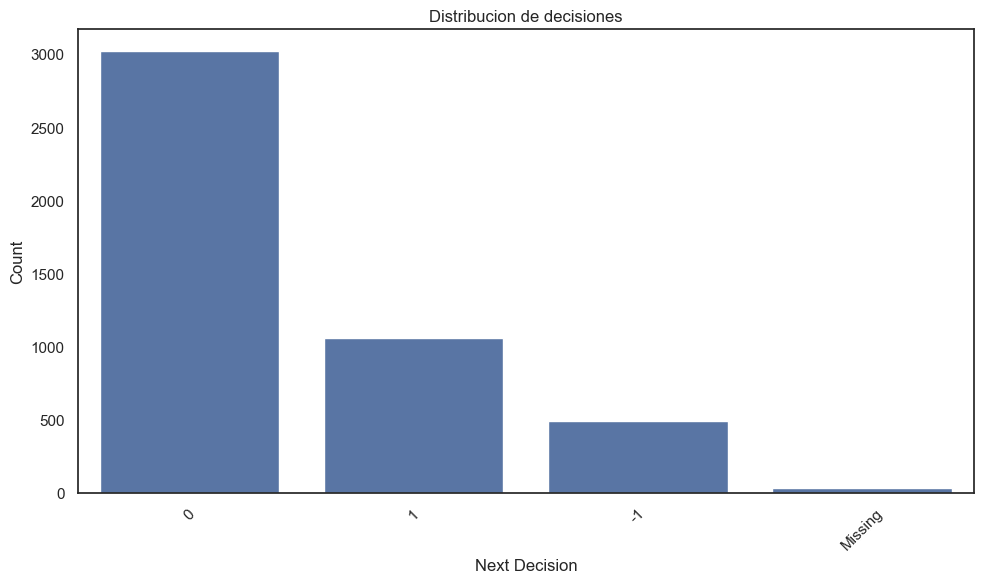

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
# Crear el gráfico de conteo
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='next_decision')

# Añadir etiquetas y título
plt.xlabel('Next Decision')
plt.ylabel('Count')
plt.title('Distribucion de decisiones')

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


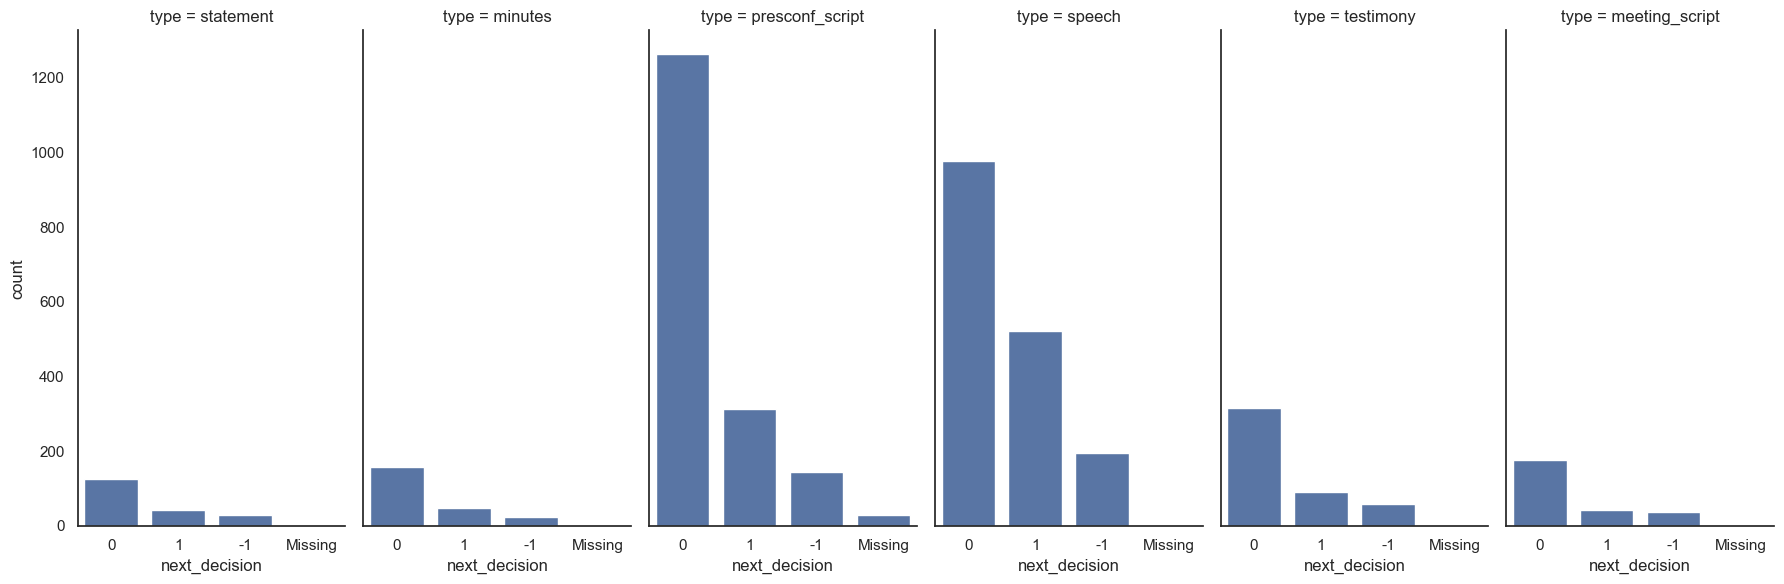

In [16]:
# Check balance of Rate Decision
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


C:\Users\luisl\AppData\Local\Temp\ipykernel_23760\4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
C:\Users\luisl\AppData\Local\Temp\ipykernel_23760\4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

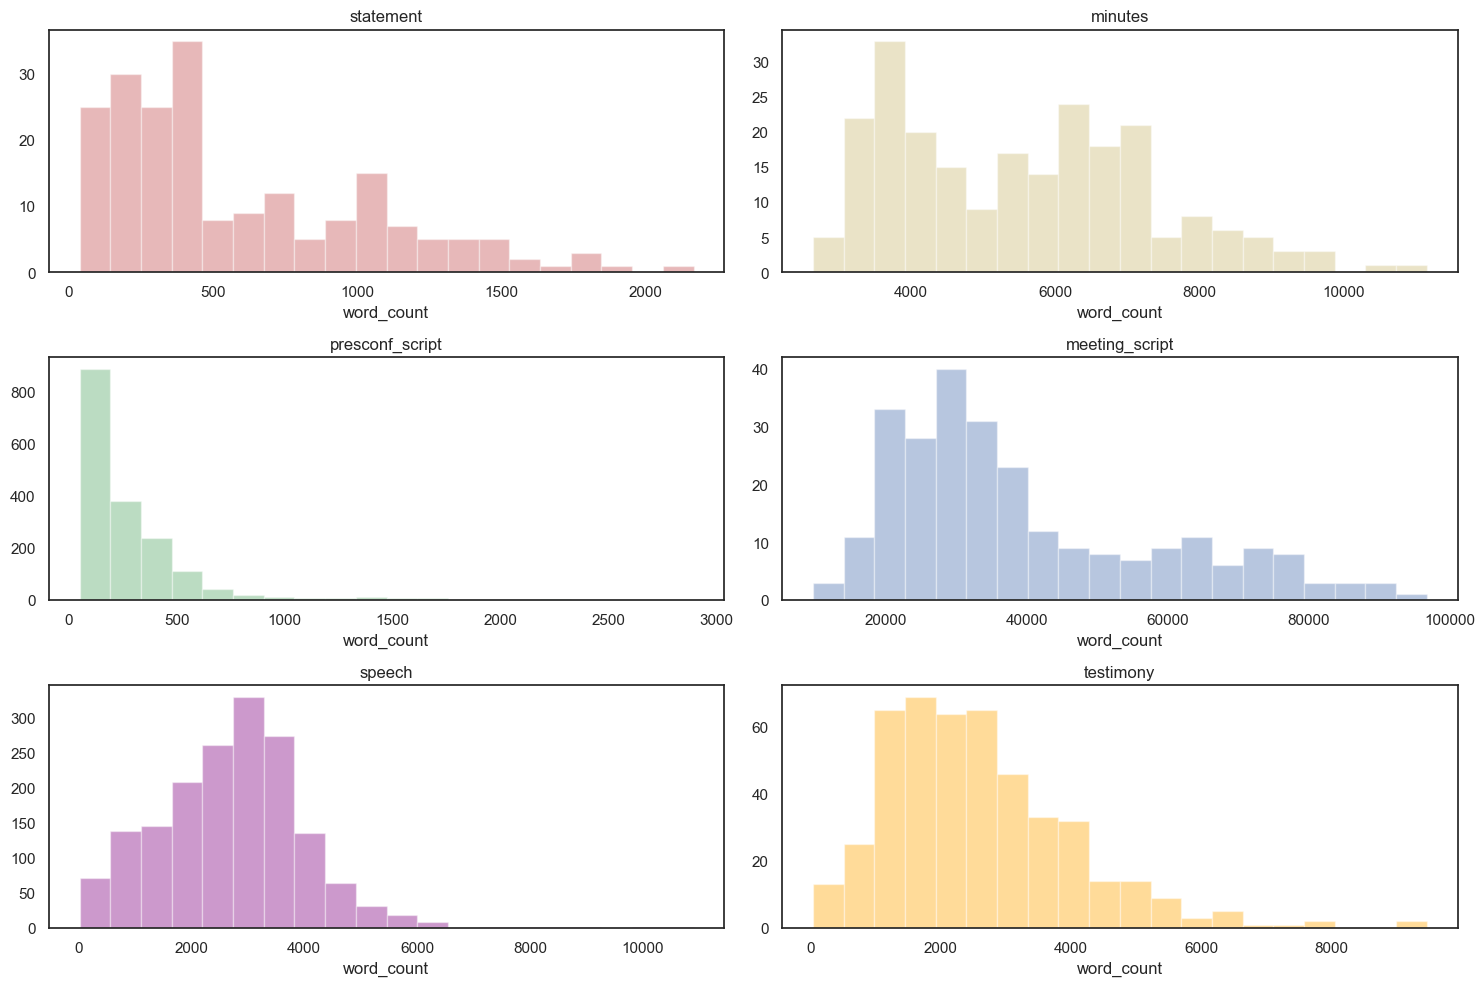

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
253,meeting_script,2014-04-30,FOMC Meeting Transcript,,78299,0,0.0,2014-06-18,0,0.0,"Good morning, everybody. Unfortunately, this i..."
254,meeting_script,2014-06-18,FOMC Meeting Transcript,,87191,0,0.0,2014-07-30,0,0.0,I'd like to begin by welcoming three people to...
255,meeting_script,2014-07-30,FOMC Meeting Transcript,,89115,0,0.0,2014-09-17,0,0.0,"Good morning, everybody. I would like to begin..."
256,meeting_script,2014-09-17,FOMC Meeting Transcript,,61267,0,0.0,2014-10-29,1,0.0,"Good morning, everybody.Our first two items th..."
257,meeting_script,2014-10-29,FOMC Meeting Transcript,,72330,1,0.0,2014-12-17,0,0.0,I'd like to call this meeting to order. Before...


In [17]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


## Load a trained model

In [18]:

train_sent_df = train_df

In [19]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [20]:
train_sent_df.shape

(4597, 11)

In [21]:
# Supongamos que quieres contar los NaN en la columna 'next_decision' de train_sent_df
nans_count = train_sent_df['next_decision'].isna().sum()

print(f"Número de valores NaN en la columna 'next_decision': {nans_count}")


Número de valores NaN en la columna 'next_decision': 0


In [22]:
train_sent_df = train_sent_df.dropna(subset=['next_decision'])
train_sent_df.shape

(4597, 11)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

## Resumir los textos mediante modelado ##

In [24]:
from transformers import BartTokenizer, BartForConditionalGeneration, pipeline

# Assuming you have your train_sent_df DataFrame with a "text" column

# Load the BART model and tokenizer (correct tokenizer choice)
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)  # Use BartTokenizer
summarizer = pipeline("summarization", model=model_name)  # This might use BART tokenizer internally



In [25]:
# Function to handle potential errors during summarization
def summarize_text(text_to_summarize):
  try:
    # Tokenize the text (using BART tokenizer with truncation)
    input_ids = tokenizer(text_to_summarize, return_tensors="pt", truncation=True).input_ids.to(device)

    # Generate summary using pipeline (easier for smaller tasks)
    summary = summarizer(text_to_summarize, truncation=True, max_length=400, num_beams=5, early_stopping=True)[0]["summary_text"]

    return summary

  except RuntimeError as e:
    print(f"Error during processing text '{text_to_summarize}': {e}")
    return None  # Or a placeholder for failed summaries

# Slice DataFrame to last 1000 rows
train_sent_df_subset = train_sent_df

# Loop through subset of DataFrame and summarize texts
for idx, row in tqdm(train_sent_df_subset.iterrows(), total=len(train_sent_df_subset)):
  text_to_summarize = row["text"]
  summary = summarize_text(text_to_summarize)

  if summary:  # Update DataFrame only if summarization succeeded
    train_sent_df_subset.loc[idx, 'summary'] = summary

# Update progress bar after loop (optional)
print("Summarization completed! Summaries added to 'summary' column.")

  0%|          | 0/4597 [00:00<?, ?it/s]

Your max_length is set to 400, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 400, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 400, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 400, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


In [ ]:
train_sent_df_subset.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
13691,speech,2023-10-02,Monetary Policy and Financial Stability,Vice Chair for Supervision Michael S. Barr,3267,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to speak to you....,I am squarely focused on our dual mandate to p...
13692,speech,2023-10-02,Brief Remarks on the Economy and Bank Regulation,Governor Michelle W. Bowman,1996,<NA>,NaN,2023-11-01,0,5.25,Thank you for the invitation to join you today...,Fed Chair Janet Yellen speaks to community ban...
13693,speech,2023-10-04,"The Role of Research, Data, and Analysis in Ba...",Governor Michelle W. Bowman,3757,<NA>,NaN,2023-11-01,0,5.25,It's a pleasure to be back in St. Louis for th...,The annual Community Banking Research Conferen...
13694,speech,2023-10-07,Brief Remarks on the Economy and Insights from...,Governor Michelle W. Bowman,2248,<NA>,NaN,2023-11-01,0,5.25,It is a pleasure to be with you here today.1 A...,"""I would like to share some thoughts about tha..."
13695,speech,2023-10-09,Capital Supports Lending,Vice Chair for Supervision Michael S. Barr,1755,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to join you toda...,Federal Reserve Chairman Janet Yellen speaks o...


guardar texto resumido como pickle

In [ ]:
import pandas as pd
import pickle

# Assuming your DataFrame is loaded and assigned to a variable named 'df'

# Define the path and filename for the pickle file
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido_v2_completo.pkl'

# Open the file in binary write mode
with open(ruta_pickle, 'wb') as pickle_file:
  # Use pickle.dump to serialize the DataFrame and write it to the file
  pickle.dump(train_sent_df_subset, pickle_file)

print("¡DataFrame guardado como archivo pickle exitosamente!")

¡DataFrame guardado como archivo pickle exitosamente!


cargar texto resumido 

In [2]:
import pickle

# Define the path to the pickle file (same as before)
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido_v2.pkl'

# Open the file in binary read mode
with open(ruta_pickle, 'rb') as pickle_file:
  # Use pickle.load to deserialize the data and create a new DataFrame
  loaded_df = pickle.load(pickle_file)

print("¡DataFrame cargado del archivo pickle exitosamente!")

¡DataFrame cargado del archivo pickle exitosamente!


C:\Users\luisl\AppData\Local\Temp\ipykernel_17068\3960296817.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  loaded_df = pickle.load(pickle_file)


In [3]:
loaded_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
13691,speech,2023-10-02,Monetary Policy and Financial Stability,Vice Chair for Supervision Michael S. Barr,3267,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to speak to you....,I am squarely focused on our dual mandate to p...
13692,speech,2023-10-02,Brief Remarks on the Economy and Bank Regulation,Governor Michelle W. Bowman,1996,<NA>,NaN,2023-11-01,0,5.25,Thank you for the invitation to join you today...,Fed Chair Janet Yellen speaks to community ban...
13693,speech,2023-10-04,"The Role of Research, Data, and Analysis in Ba...",Governor Michelle W. Bowman,3757,<NA>,NaN,2023-11-01,0,5.25,It's a pleasure to be back in St. Louis for th...,The annual Community Banking Research Conferen...
13694,speech,2023-10-07,Brief Remarks on the Economy and Insights from...,Governor Michelle W. Bowman,2248,<NA>,NaN,2023-11-01,0,5.25,It is a pleasure to be with you here today.1 A...,"""I would like to share some thoughts about tha..."
13695,speech,2023-10-09,Capital Supports Lending,Vice Chair for Supervision Michael S. Barr,1755,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to join you toda...,Federal Reserve Chairman Janet Yellen speaks o...


In [4]:
def equilibrar_columna_ignorando_missing(df, columna, valor_missing='Missing'):
    """
    Equilibra los valores en una columna específica de un DataFrame de pandas,
    ignorando los valores faltantes.
    
    Parámetros:
    - df: DataFrame de pandas.
    - columna: Nombre de la columna a equilibrar.
    - valor_missing: Valor que representa los datos faltantes en la columna.
    
    Retorna:
    - DataFrame equilibrado donde cada valor único en la columna especificada
      (excepto el valor_missing) tiene el mismo número de filas.
    """
    # Filtra los valores faltantes
    df_filtrado = df[df[columna] != valor_missing]
    
    # Calcula el número de filas para cada valor único en la columna filtrada
    counts = df_filtrado[columna].value_counts()
    
    # Encuentra el valor mínimo de filas entre los grupos
    min_count = counts.min()
    
    # Reduce cada grupo a este número mínimo de filas
    balanced_df = df_filtrado.groupby(columna).head(min_count).reset_index(drop=True)
    
    return balanced_df


In [5]:
# Uso de la función
# Suponiendo que train_sent_df es tu DataFrame, 'next_decision' es la columna a equilibrar,
# y 'Missing' representa los valores faltantes en esa columna
train_sent_df = equilibrar_columna_ignorando_missing(loaded_df, 'next_decision', 'Missing')

# Verificación del nuevo balance de clases (sin contar los missing)

In [6]:
print(train_sent_df['next_decision'].value_counts())

next_decision
0     58
1     58
-1    58
Name: count, dtype: int64


In [7]:
X = train_sent_df['summary'].to_list()


In [8]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
0,speech,2023-10-02,Monetary Policy and Financial Stability,Vice Chair for Supervision Michael S. Barr,3267,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to speak to you....,I am squarely focused on our dual mandate to p...
1,speech,2023-10-02,Brief Remarks on the Economy and Bank Regulation,Governor Michelle W. Bowman,1996,<NA>,NaN,2023-11-01,0,5.25,Thank you for the invitation to join you today...,Fed Chair Janet Yellen speaks to community ban...
2,speech,2023-10-04,"The Role of Research, Data, and Analysis in Ba...",Governor Michelle W. Bowman,3757,<NA>,NaN,2023-11-01,0,5.25,It's a pleasure to be back in St. Louis for th...,The annual Community Banking Research Conferen...
3,speech,2023-10-07,Brief Remarks on the Economy and Insights from...,Governor Michelle W. Bowman,2248,<NA>,NaN,2023-11-01,0,5.25,It is a pleasure to be with you here today.1 A...,"""I would like to share some thoughts about tha..."
4,speech,2023-10-09,Capital Supports Lending,Vice Chair for Supervision Michael S. Barr,1755,<NA>,NaN,2023-11-01,0,5.25,Thank you for the opportunity to join you toda...,Federal Reserve Chairman Janet Yellen speaks o...


In [9]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['summary'].to_list()




In [10]:
nan_count = submuestra_df['next_decision'].isnull().sum()
nan_count

0

In [11]:
data = train_sent_df[['summary', 'next_decision']]
# Reemplazar los valores en la columna específica
data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})

C:\Users\luisl\AppData\Local\Temp\ipykernel_17068\1924414100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})
C:\Users\luisl\AppData\Local\Temp\ipykernel_17068\1924414100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['next_decision'] = data['next_decision'].replace({1: 2, 0: 1, -1: 0})


In [12]:
data = data.rename(columns={'summary': 'text', 'next_decision': 'label'})

In [13]:
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en conjuntos de entrenamiento y prueba (80% train, 20% test)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Mostrar los tamaños de los conjuntos de train y test
print("Tamaño del conjunto de entrenamiento:", len(train_df))
print("Tamaño del conjunto de prueba:", len(test_df))

Tamaño del conjunto de entrenamiento: 139
Tamaño del conjunto de prueba: 35


In [14]:
train_data = train_df.to_dict(orient='records')
val_data = test_df.to_dict(orient='records')
data = data.to_dict(orient='records')



In [15]:
train_data

[{'text': 'U.S. budget ran a deficit equal to about 3-1/2 percent of gross domestic product in fiscal 2004. Federal debt held by the public as a percentof GDP has risen noticeably since it bottomed out in 2001. Reinstating a structure like the one provided by the Budget Enforcement Act would signal commitment to fiscal restraint.',
  'label': 2},
 {'text': 'Over 17 percent of subprime adjustable-rate mortgages were in serious delinquency at the end of September, a rate over three times higher than that in mid-2005. Serious delinquencies also increased among near-prime and prime mortgages, although these delinquencies remain much lower than among subprime mortgages. Lenders initiated foreclosure proceedings for an average of 320,000 loans per quarter in the first half of this year.',
  'label': 0},
 {'text': 'The Dodd-Frank Act addresses key gaps in the framework for supervising and regulating systemically important financial institutions. It also addresses the market perception that su

fine tuning del primer modelo

In [17]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
import os

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_{lr}_{batch_size}_V2.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/9 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\luisl\AppData\Local\Temp\ipykernel_10892\3498061804.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 1.2998, Train Accuracy: 0.3182
Validation Loss: 1.1954, Validation Accuracy: 0.3611
Saving best model with validation accuracy: 0.3611


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.0544, Train Accuracy: 0.4116
Validation Loss: 1.1263, Validation Accuracy: 0.3403


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.9866, Train Accuracy: 0.5082
Validation Loss: 1.1177, Validation Accuracy: 0.3194
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.0183, Train Accuracy: 0.4795
Validation Loss: 1.1479, Validation Accuracy: 0.3542


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.8780, Train Accuracy: 0.5835
Validation Loss: 1.1945, Validation Accuracy: 0.3073
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.8252, Train Accuracy: 0.5777
Validation Loss: 1.4669, Validation Accuracy: 0.3714
Saving best model with validation accuracy: 0.3714


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.7774, Train Accuracy: 0.6487
Validation Loss: 1.4161, Validation Accuracy: 0.3429


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.7959, Train Accuracy: 0.6004
Validation Loss: 1.4265, Validation Accuracy: 0.3429
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.7439, Train Accuracy: 0.6338
Validation Loss: 1.2619, Validation Accuracy: 0.4236
Saving best model with validation accuracy: 0.4236


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.5429, Train Accuracy: 0.7816
Validation Loss: 1.5707, Validation Accuracy: 0.3819


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.3568, Train Accuracy: 0.8788
Validation Loss: 1.7058, Validation Accuracy: 0.4653
Saving best model with validation accuracy: 0.4653


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3057, Train Accuracy: 0.9006
Validation Loss: 1.7992, Validation Accuracy: 0.4010


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1838, Train Accuracy: 0.9318
Validation Loss: 2.0913, Validation Accuracy: 0.2188
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.2506, Train Accuracy: 0.8916
Validation Loss: 2.0562, Validation Accuracy: 0.4286


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2268, Train Accuracy: 0.8925
Validation Loss: 2.3756, Validation Accuracy: 0.4286
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.5932, Train Accuracy: 0.7538
Validation Loss: 2.5770, Validation Accuracy: 0.3611


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.6072, Train Accuracy: 0.7790
Validation Loss: 1.7931, Validation Accuracy: 0.3333
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.5341, Train Accuracy: 0.8193
Validation Loss: 2.6057, Validation Accuracy: 0.2500


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2867, Train Accuracy: 0.9256
Validation Loss: 2.3297, Validation Accuracy: 0.2500
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.3259, Train Accuracy: 0.8613
Validation Loss: 1.9431, Validation Accuracy: 0.5143
Saving best model with validation accuracy: 0.5143


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1099, Train Accuracy: 0.9489
Validation Loss: 1.9582, Validation Accuracy: 0.5143


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0620, Train Accuracy: 0.9844
Validation Loss: 2.0828, Validation Accuracy: 0.5429
Saving best model with validation accuracy: 0.5429


carga del primer modelo reentrenado

In [16]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_5e-05_64_V2.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is booming!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is booming!': positive


twitter-roberta-base-sentiment Model¶


In [17]:
import torch
import numpy as np
import scipy.special
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_roberta.load_state_dict(torch.load(model_path))
model_roberta.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Asumiendo que X_submuestra es tu lista de textos a analizar
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Procesando predicciones"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        # Obtener las logits del modelo
        logits = model_roberta(**input_sequence).logits
        # Aplicar softmax en la GPU
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    
    sentimiento_general = labels[np.argmax(scores)]
    probabilidad_general = np.max(scores)
    
    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


Procesando predicciones: 100%|██████████| 174/174 [00:05<00:00, 32.92it/s]


In [18]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
22,speech,2023-11-08,Opening Remarks,Chair Jerome H. Powell,760,<NA>,NaN,2023-12-13,0,5.25,"Thank you, Stacey, for the chance to be part o...",The Fed is celebrating the 100th anniversary o...,neutral
125,testimony,2005-07-20,Federal Reserve Board's semiannual Monetary Po...,Alan Greenspan,3253,<NA>,NaN,2005-08-09,1,3.50,"In mid-February,when I presented our last repo...",The economy appeared to be on a solid growth p...,positive
164,testimony,2012-05-17,Settlement practices,"Scott G. Alvarez, General Counsel",1774,<NA>,NaN,2012-06-20,-1,0.00,"Introduction Chairman Bachus, Ranking Me...",The Federal Reserve has supervisory authority ...,negative
9,speech,2023-10-18,The Evolution of the Federal Reserveâs Emplo...,Governor Lisa D. Cook,1592,<NA>,NaN,2023-11-01,0,5.25,"Thank you. I am rarely at a loss for words, as...",Federal Reserve Chair Janet Yellen is given th...,neutral
46,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4100,<NA>,NaN,1997-03-25,1,5.50,"Madam Chairwoman, members of the Subcommittee ...",The Federal Reserve Board supports expanded fi...,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,speech,2023-10-19,Opening Remarks,Vice Chair Philip N. Jefferson,710,<NA>,NaN,2023-11-01,0,5.25,Our guests include academics from a number of ...,The U.S. Treasury market remains the largest a...,neutral
51,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,2142,<NA>,NaN,1997-03-25,1,5.50,"Mr. Chairman and members of the Committee, I a...","Mr. Chairman, I would like to highlight some o...",neutral
43,testimony,1996-09-18,Implications of trading losses by Sumitomo Corp.,Governor Susan M. Phillips,1283,<NA>,NaN,1996-09-24,0,5.25,Thank you for the opportunity to discuss the r...,Sumitomo's copper trading losses may be as lar...,neutral
14,speech,2023-10-19,Multiple Scenarios in Stress Testing,Vice Chair for Supervision Michael S. Barr,2378,<NA>,NaN,2023-11-01,0,5.25,The stress test as we know it today grew out o...,The Federal Reserve conducts an annual stress ...,neutral


yiyanghkust/finbert-tone Model

In [18]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_roberta = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_2_{lr}_{batch_size}_V2.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/9 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\luisl\AppData\Local\Temp\ipykernel_10892\2321675807.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 4.5154, Train Accuracy: 0.3081
Validation Loss: 2.7183, Validation Accuracy: 0.4514
Saving best model with validation accuracy: 0.4514


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.9676, Train Accuracy: 0.3876
Validation Loss: 1.8457, Validation Accuracy: 0.3611


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.1586, Train Accuracy: 0.4710
Validation Loss: 1.6918, Validation Accuracy: 0.3611
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.8629, Train Accuracy: 0.6080
Validation Loss: 1.4716, Validation Accuracy: 0.3698


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.5716, Train Accuracy: 0.7875
Validation Loss: 1.8021, Validation Accuracy: 0.4010
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.5837, Train Accuracy: 0.7633
Validation Loss: 1.2877, Validation Accuracy: 0.4857
Saving best model with validation accuracy: 0.4857


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.4663, Train Accuracy: 0.8655
Validation Loss: 1.3221, Validation Accuracy: 0.4571


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.3071, Train Accuracy: 0.8906
Validation Loss: 1.4701, Validation Accuracy: 0.4571
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.4223, Train Accuracy: 0.8163
Validation Loss: 1.8895, Validation Accuracy: 0.4444


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1664, Train Accuracy: 0.9514
Validation Loss: 2.2473, Validation Accuracy: 0.4236
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1079, Train Accuracy: 0.9443
Validation Loss: 2.6508, Validation Accuracy: 0.2500


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0334, Train Accuracy: 1.0000
Validation Loss: 2.6622, Validation Accuracy: 0.4167
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0443, Train Accuracy: 0.9948
Validation Loss: 2.3211, Validation Accuracy: 0.5714
Saving best model with validation accuracy: 0.5714


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0190, Train Accuracy: 0.9948
Validation Loss: 2.2351, Validation Accuracy: 0.5143


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0202, Train Accuracy: 0.9948
Validation Loss: 2.3643, Validation Accuracy: 0.4857
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0815, Train Accuracy: 0.9653
Validation Loss: 4.1260, Validation Accuracy: 0.3819


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2756, Train Accuracy: 0.9274
Validation Loss: 3.3455, Validation Accuracy: 0.2917
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0124, Train Accuracy: 1.0000
Validation Loss: 4.9242, Validation Accuracy: 0.2500


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0566, Train Accuracy: 0.9750
Validation Loss: 5.6513, Validation Accuracy: 0.4479
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0016, Train Accuracy: 1.0000
Validation Loss: 4.8915, Validation Accuracy: 0.4286


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0195, Train Accuracy: 0.9948
Validation Loss: 3.5892, Validation Accuracy: 0.5429
Early stopping triggered after 2 epochs without improvement


carga de segundo modelo reentrenado

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_2_2e-05_64_V2.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is doing great!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is doing great!': neutral


In [20]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd
from tqdm.auto import tqdm

# Inicialización del modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert.load_state_dict(torch.load(model_path))
finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert.to(device)

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Asumiendo que submuestra_df es tu DataFrame y tiene una columna 'text'
predicted_finbert_tone = []

for text in tqdm(submuestra_df['summary'], desc="Analizando sentimientos"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        result = nlp(text)[0]
    
    sentimiento_final = result['label'].lower()
    predicted_finbert_tone.append(sentimiento_final)

# Añadir los resultados al DataFrame
submuestra_df['predicted_finbertTone'] = predicted_finbert_tone


Analizando sentimientos:   0%|          | 0/174 [00:00<?, ?it/s]

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\transformers\pipelines\base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


ProsusAI/finbert Model


In [19]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_roberta = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Function to preprocess data (replace with your data loading logic)
def preprocess_data(data):
  # Tokenize text and convert labels to tensors
  input_ids = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
  attention_mask = tokenizer(data["text"], return_tensors="pt", padding=True, truncation=True).attention_mask.to(device)
  labels = torch.tensor(data["label"]).to(device)
  return input_ids, attention_mask, labels

from transformers import AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as pd
from torch.utils.data import DataLoader

# Define training and validation functions
def train(model, optimizer, train_data, epoch, writer):
  model.train()
  losses = []
  accuracies = []
  for data in tqdm(train_data):
    input_ids, attention_mask, labels = preprocess_data(data)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    loss = torch.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    # Calculate accuracy
    predictions = torch.argmax(logits, dim=1)
    correct = (predictions == labels).sum().item()
    accuracy = correct / len(labels)
    accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", avg_accuracy, epoch)
  print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

def validate(model, val_data, writer, epoch):
  model.eval()
  losses = []
  accuracies = []
  with torch.no_grad():
    for data in val_data:
      input_ids, attention_mask, labels = preprocess_data(data)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      loss = torch.nn.functional.cross_entropy(logits, labels)
      losses.append(loss.item())
      # Calculate accuracy
      predictions = torch.argmax(logits, dim=1)
      correct = (predictions == labels).sum().item()
      accuracy = correct / len(labels)
      accuracies.append(accuracy)
  avg_loss = np.mean(losses)
  avg_accuracy = np.mean(accuracies)
  writer.add_scalar("Val/Loss", avg_loss, epoch)
  writer.add_scalar("Val/Accuracy", avg_accuracy, epoch)
  print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy:.4f}")
  return avg_loss, avg_accuracy

# Hyperparameter tuning (experiment with different learning rates and batch sizes)
learning_rates = [1e-5, 2e-5, 5e-5]
batch_sizes = [16, 32, 64]

# Load your training and validation data (replace with your data)
train_data = train_data  # Load your training data here
val_data = val_data  # Load your validation data here

# Train-validation loop with hyperparameter search
best_val_accuracy = 0
for lr in learning_rates:
  for batch_size in batch_sizes:
    # Define optimizer and data loaders
    optimizer = AdamW(model_roberta.parameters(), lr=lr)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Early stopping variables
    epochs = 3  # Set the number of epochs
    patience = 2  # Number of epochs to wait for improvement
    no_improvement = 0

    # TensorBoard for visualization (optional)
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f"runs/roberta_sentiment_{lr}_{batch_size}")

    for epoch in range(epochs):
      train_loss, train_acc = train(model_roberta, optimizer, train_loader, epoch, writer)
      val_loss, val_acc = validate(model_roberta, val_loader, writer, epoch)

      # Define a variable for the desired save directory
      save_directory = "C:\\Users\\luisl\\OneDrive\\Escritorio\\TFM_IA3\\tfm_ia3_nodata\\models"  # Ensure double backslashes for Windows paths

      # Early stopping with model saving
      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          no_improvement = 0
          # Save the best model in the specified directory
          torch.save(model_roberta.state_dict(), os.path.join(save_directory, f"best_model_3_{lr}_{batch_size}_V2.pt"))
          print(f"Saving best model with validation accuracy: {val_acc:.4f}")
      else:
          no_improvement += 1
          if no_improvement >= patience:
              print(f"Early stopping triggered after {no_improvement} epochs without improvement")
              break  # Exit the inner loop for this hyperparameter combination

  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\luisl\AppData\Local\Temp\ipykernel_10892\2258492466.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data["label"]).to(device)


Epoch 1 - Train Loss: 1.8500, Train Accuracy: 0.3251
Validation Loss: 1.8939, Validation Accuracy: 0.2292
Saving best model with validation accuracy: 0.2292


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.2742, Train Accuracy: 0.4362
Validation Loss: 1.4914, Validation Accuracy: 0.1250


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.9991, Train Accuracy: 0.4874
Validation Loss: 1.3259, Validation Accuracy: 0.2778
Saving best model with validation accuracy: 0.2778


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.9333, Train Accuracy: 0.5466
Validation Loss: 1.3144, Validation Accuracy: 0.2604


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.8064, Train Accuracy: 0.6767
Validation Loss: 1.3467, Validation Accuracy: 0.1094
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.7256, Train Accuracy: 0.6870
Validation Loss: 1.4861, Validation Accuracy: 0.2286


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.5820, Train Accuracy: 0.7727
Validation Loss: 1.6398, Validation Accuracy: 0.2857
Saving best model with validation accuracy: 0.2857


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.4969, Train Accuracy: 0.8187
Validation Loss: 1.6377, Validation Accuracy: 0.2286


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.4400, Train Accuracy: 0.8024
Validation Loss: 1.8574, Validation Accuracy: 0.1875


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2080, Train Accuracy: 0.9653
Validation Loss: 2.1001, Validation Accuracy: 0.1458
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1438, Train Accuracy: 0.9574
Validation Loss: 2.3367, Validation Accuracy: 0.0938


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0830, Train Accuracy: 1.0000
Validation Loss: 2.5008, Validation Accuracy: 0.1562
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1084, Train Accuracy: 0.9740
Validation Loss: 2.2263, Validation Accuracy: 0.2571


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1146, Train Accuracy: 0.9844
Validation Loss: 2.2230, Validation Accuracy: 0.2571
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1176, Train Accuracy: 0.9583
Validation Loss: 3.0867, Validation Accuracy: 0.2778


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.1589, Train Accuracy: 0.9514
Validation Loss: 2.6387, Validation Accuracy: 0.3403
Saving best model with validation accuracy: 0.3403


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0444, Train Accuracy: 0.9830
Validation Loss: 3.0590, Validation Accuracy: 0.1875


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.0504, Train Accuracy: 0.9938
Validation Loss: 3.3749, Validation Accuracy: 0.1875


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.0199, Train Accuracy: 1.0000
Validation Loss: 3.7699, Validation Accuracy: 0.1562
Early stopping triggered after 2 epochs without improvement


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.1669, Train Accuracy: 0.9427
Validation Loss: 2.7645, Validation Accuracy: 0.4857
Saving best model with validation accuracy: 0.4857


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.2284, Train Accuracy: 0.9271
Validation Loss: 2.7838, Validation Accuracy: 0.4000


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.0077, Train Accuracy: 1.0000
Validation Loss: 2.6771, Validation Accuracy: 0.3714
Early stopping triggered after 2 epochs without improvement


cargar tercer modelo reentrenado

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_3_5e-05_64_V2.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is doing great!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")


Predicted sentiment for 'The stock market is doing great!': negative


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as np

# Inicialización del tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finbert.to(device)

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in tqdm(X_submuestra, desc="Procesando predicciones FinBERT"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        logits = model_finbert(**input_sequence).logits
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        scores_dict = {
            label: score
            for label, score in zip(model_finbert.config.id2label.values(), scores)
        }
        sentimiento = max(scores_dict, key=scores_dict.get)
        probabilidad = max(scores_dict.values())
    
    preds.append(sentimiento)
    preds_proba.append(probabilidad)



Procesando predicciones FinBERT:   0%|          | 0/174 [00:00<?, ?it/s]

In [23]:
submuestra_df['predicted_finbert'] =preds

hacer la columna sentiment en el dataset de entrenamiento teniendo en cuenta las agregaciones de key y cambiar de 1 a positive etc

In [24]:

y = submuestra_df['next_decision'].to_list()
y = [ 'neutral' if value == 0 else 'positive' if value == 1 else 'negative' for value in y ]


In [25]:
submuestra_df.tail()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta,predicted_finbertTone,predicted_finbert
12,speech,2023-10-19,Opening Remarks,Vice Chair Philip N. Jefferson,710,<NA>,NaN,2023-11-01,0,5.25,Our guests include academics from a number of ...,The U.S. Treasury market remains the largest a...,neutral,neutral,positive
51,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,2142,<NA>,NaN,1997-03-25,1,5.50,"Mr. Chairman and members of the Committee, I a...","Mr. Chairman, I would like to highlight some o...",neutral,positive,positive
43,testimony,1996-09-18,Implications of trading losses by Sumitomo Corp.,Governor Susan M. Phillips,1283,<NA>,NaN,1996-09-24,0,5.25,Thank you for the opportunity to discuss the r...,Sumitomo's copper trading losses may be as lar...,neutral,positive,negative
14,speech,2023-10-19,Multiple Scenarios in Stress Testing,Vice Chair for Supervision Michael S. Barr,2378,<NA>,NaN,2023-11-01,0,5.25,The stress test as we know it today grew out o...,The Federal Reserve conducts an annual stress ...,neutral,positive,negative
29,speech,2023-11-16,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,2176,<NA>,NaN,2023-12-13,0,5.25,The flash rally in the Treasury market in Octo...,The flash rally in the Treasury market in Octo...,neutral,neutral,positive


In [26]:
submuestra_df['text'][0]

'Thank you for the opportunity to speak to you. I would like to talk with you today about the intersection of my two roles at the Federal Reserve as the Vice Chair for Supervision at the Federal Reserve Board and as a member of the Federal Open Market Committee (FOMC).1 In particular, I\'ll focus on the interaction of monetary policy and financial stability policy. I am squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. I strongly agree with the point that Chair Powell has made often, which is that without price stability, the economy does not work for anyone. Price stability is crucial to achieving a sustained period of strong labor market conditions that benefit all. I joined the FOMC last year at a time when the headline CPI inflation was peaking at about 9 percent, and we had begun our policy response. There has been a lot of progress since tightening the stance of policy began last year. In August, the 12-month change in C

## Model evaluation

In [27]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [30]:
evaluate_model_accuracy('ProsusAI/finbert', preds)
evaluate_model_accuracy('cardiffnlp/twitter-roberta-base-sentiment', preds_roberta)
evaluate_model_accuracy('yiyanghkust/finbert-tone', submuestra_df.predicted_finbertTone)

Model: ProsusAI/finbert - Accuracy-Score: 0.0977
Model: cardiffnlp/twitter-roberta-base-sentiment - Accuracy-Score: 0.8908
Model: yiyanghkust/finbert-tone - Accuracy-Score: 0.0517


In [31]:
print(classification_report(y,preds))
print(classification_report(y,preds_roberta))
print(classification_report(y,submuestra_df.predicted_finbertTone))

              precision    recall  f1-score   support

    negative       0.02      0.02      0.02        58
     neutral       0.02      0.02      0.02        58
    positive       0.20      0.26      0.23        58

    accuracy                           0.10       174
   macro avg       0.08      0.10      0.09       174
weighted avg       0.08      0.10      0.09       174

              precision    recall  f1-score   support

    negative       0.98      0.86      0.92        58
     neutral       0.80      0.95      0.87        58
    positive       0.93      0.86      0.89        58

    accuracy                           0.89       174
   macro avg       0.90      0.89      0.89       174
weighted avg       0.90      0.89      0.89       174

              precision    recall  f1-score   support

    negative       0.03      0.03      0.03        58
     neutral       0.08      0.09      0.08        58
    positive       0.04      0.03      0.04        58

    accuracy        

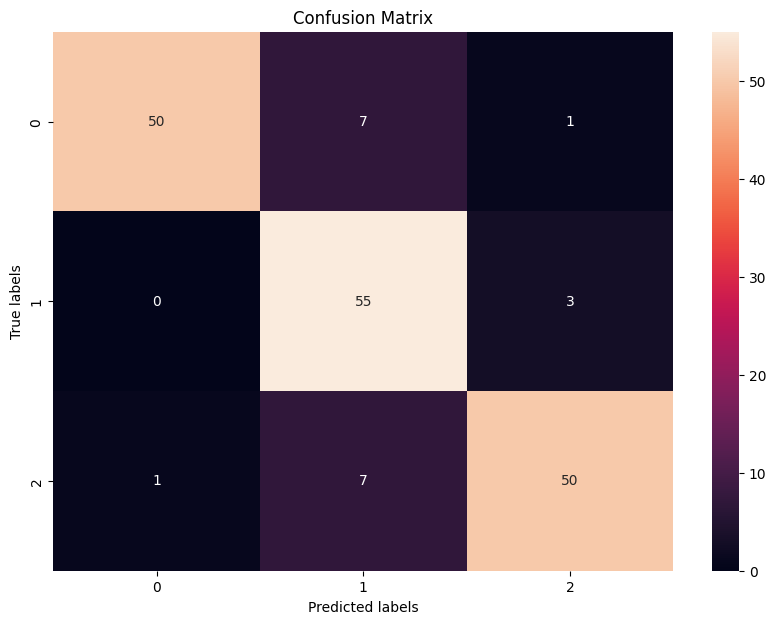

In [32]:
cm = confusion_matrix(y, preds_roberta)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

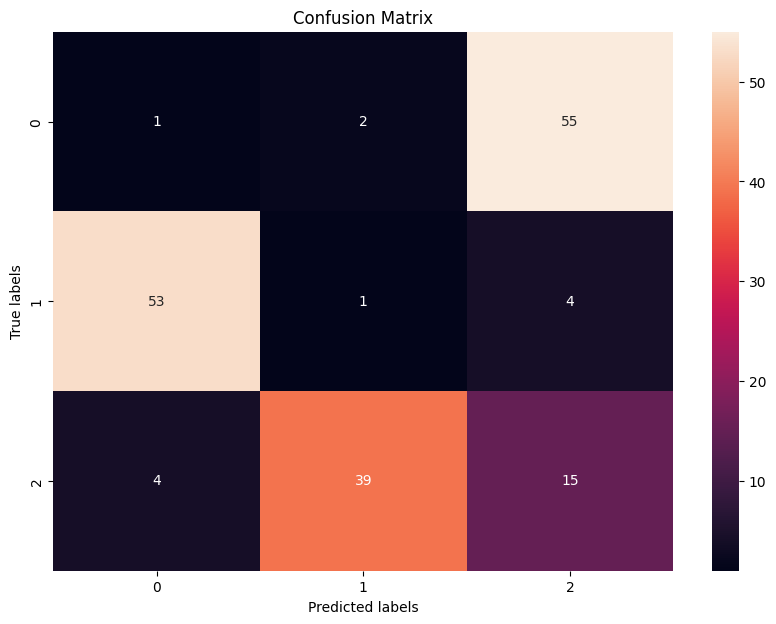

In [33]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

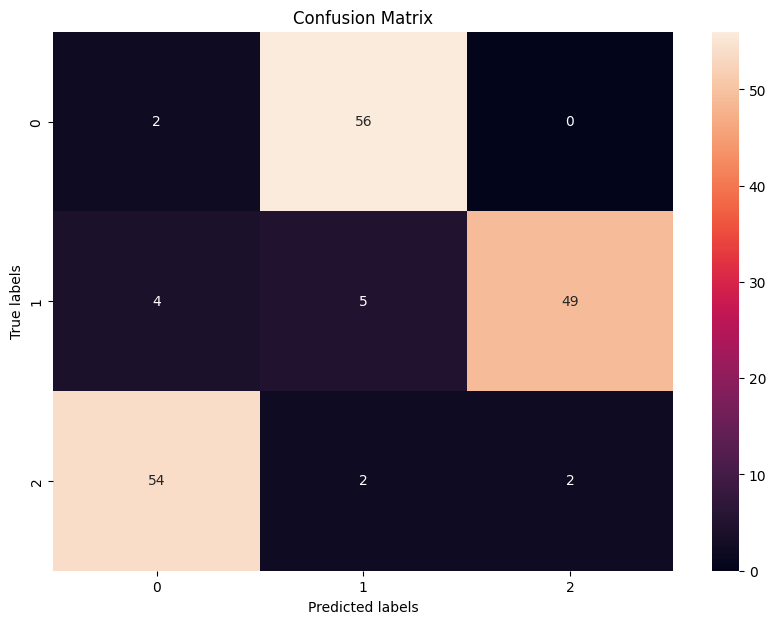

In [34]:
cm = confusion_matrix(y, submuestra_df.predicted_finbertTone)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()